In [1]:
#  IMPORTS AND SETUP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve)
import joblib
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Create directories if they don't exist
Path('models').mkdir(exist_ok=True)
Path('logs').mkdir(exist_ok=True)

print("LOAN PAYBACK PREDICTION - ML MODEL TRAINING")
print("\n All libraries imported successfully!")

LOAN PAYBACK PREDICTION - ML MODEL TRAINING

 All libraries imported successfully!


In [2]:
#  DATA LOADING
print("\n [STEP 1] Loading Dataset...")
# Load the dataset
df = pd.read_csv('train.csv')
print(f"\n Dataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")




 [STEP 1] Loading Dataset...

 Dataset Shape: (593994, 13)
   Rows: 593,994
   Columns: 13


In [3]:
# EXPLORATORY DATA ANALYSIS
print("EXPLORATORY DATA ANALYSIS")
print("\n First 5 rows:")
print(df.head())

print("\n Dataset Info:")
df.info()

print("\n Column Names:")
print(df.columns.tolist())

print("\n Data Types:")
print(df.dtypes)

print("\n Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values!")

print("\n Basic Statistics:")
print(df.describe())


EXPLORATORY DATA ANALYSIS

 First 5 rows:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  interest_rate  gender marital_status education_level employment_status        loan_purpose grade_subgrade  loan_paid_back
0   0       29367.99                 0.084           736      2528.42          13.67  Female         Single     High School     Self-employed               Other             C3             1.0
1   1       22108.02                 0.166           636      4593.10          12.92    Male        Married        Master's          Employed  Debt consolidation             D3             0.0
2   2       49566.20                 0.097           694     17005.15           9.76    Male         Single     High School          Employed  Debt consolidation             C5             1.0
3   3       46858.25                 0.065           533      4682.48          16.10  Female         Single     High School          Employed  Debt consolidation             F1          

IDENTIFYING TARGET COLUMN

  Could not auto-detect target column.

Available columns:
  1. id
  2. annual_income
  3. debt_to_income_ratio
  4. credit_score
  5. loan_amount
  6. interest_rate
  7. gender
  8. marital_status
  9. education_level
  10. employment_status
  11. loan_purpose
  12. grade_subgrade
  13. loan_paid_back

→ Using last column as target: 'loan_paid_back'

 Target Column: 'loan_paid_back'
   Unique Values: 2

   Distribution:
loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

   Percentage:
loan_paid_back
1.0    79.881952
0.0    20.118048
Name: proportion, dtype: float64


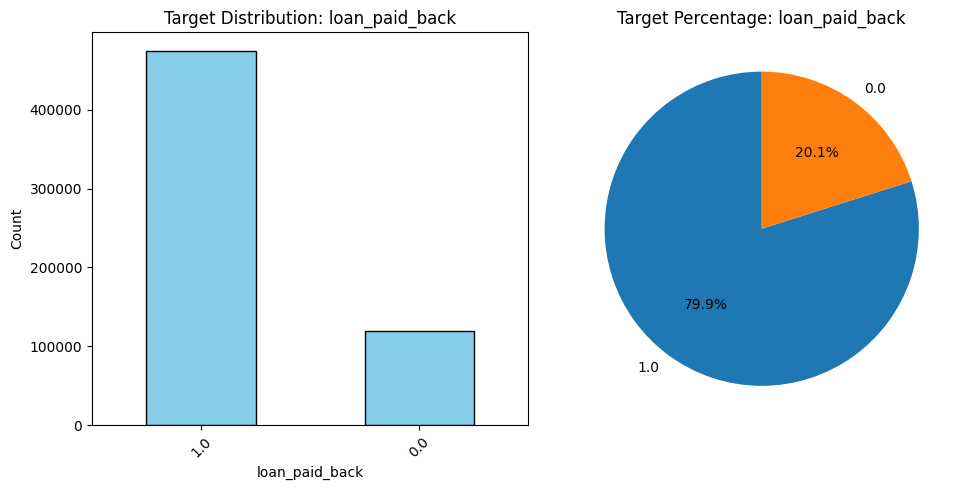

In [4]:
# IDENTIFY TARGET COLUMN
print("IDENTIFYING TARGET COLUMN")

# Common target column names
target_candidates = [
    'loan_status', 'paid_back', 'default', 'target', 'label', 
    'status', 'outcome', 'payment_status', 'loan_repaid',
    'fully_paid', 'charged_off', 'not_fully_paid'
]

target_col = None

for col in target_candidates:
    if col in df.columns:
        target_col = col
        print(f" Target column found: '{target_col}'")
        break

if target_col is None:
    print("\n  Could not auto-detect target column.")
    print("\nAvailable columns:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")
    
    if df.iloc[:, -1].nunique() <= 10:
        target_col = df.columns[-1]
        print(f"\n→ Using last column as target: '{target_col}'")
    else:
    
        print("\n  Please manually set target_col variable in next cell")
        print("   Example: target_col = 'loan_status'")

# Display target information
if target_col:
    print(f"\n Target Column: '{target_col}'")
    print(f"   Unique Values: {df[target_col].nunique()}")
    print(f"\n   Distribution:")
    print(df[target_col].value_counts())
    print(f"\n   Percentage:")
    print(df[target_col].value_counts(normalize=True) * 100)
    
    # Visualize target distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    df[target_col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Target Distribution: {target_col}')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'Target Percentage: {target_col}')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()


In [5]:
#  DATA PREPROCESSING
print("DATA PREPROCESSING")

df_clean = df.copy()

print(f"\n Initial shape: {df_clean.shape}")
print(f"   Missing values: {df_clean.isnull().sum().sum()}")

if df_clean.isnull().sum().sum() > 0:
    print("\n Handling missing values...")
    
    
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
            print(f"    Filled {col} with median")
    
    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
            print(f"    Filled {col} with mode")
    
    print(f"\n Missing values after cleaning: {df_clean.isnull().sum().sum()}")
else:
    print(" No missing values to handle!")

print(f" Final shape: {df_clean.shape}")


DATA PREPROCESSING

 Initial shape: (593994, 13)
   Missing values: 0
 No missing values to handle!
 Final shape: (593994, 13)


In [6]:
#  FEATURE AND TARGET SEPARATION
print("SEPARATING FEATURES AND TARGET")

# Separate features and target
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col} ({X[col].dtype})")



SEPARATING FEATURES AND TARGET
 Features shape: (593994, 12)
 Target shape: (593994,)

Feature columns (12):
  1. id (int64)
  2. annual_income (float64)
  3. debt_to_income_ratio (float64)
  4. credit_score (int64)
  5. loan_amount (float64)
  6. interest_rate (float64)
  7. gender (object)
  8. marital_status (object)
  9. education_level (object)
  10. employment_status (object)
  11. loan_purpose (object)
  12. grade_subgrade (object)


In [7]:
# ENCODE CATEGORICAL FEATURES
print("ENCODING CATEGORICAL FEATURES")

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns found: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\nEncoding categorical features...")
    label_encoders = {}
    
    for col in categorical_cols:
        print(f"  Encoding '{col}'...")
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"     {len(le.classes_)} unique values encoded")
    
    # Save label encoders
    with open('models/label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    print(f"\n Label encoders saved to 'models/label_encoders.pkl'")
else:
    print(" No categorical columns to encode!")
    label_encoders = {}



ENCODING CATEGORICAL FEATURES

Categorical columns found: 6

Encoding categorical features...
  Encoding 'gender'...
     3 unique values encoded
  Encoding 'marital_status'...
     4 unique values encoded
  Encoding 'education_level'...
     5 unique values encoded
  Encoding 'employment_status'...
     5 unique values encoded
  Encoding 'loan_purpose'...
     8 unique values encoded
  Encoding 'grade_subgrade'...
     30 unique values encoded

 Label encoders saved to 'models/label_encoders.pkl'


In [8]:
#  ENCODE TARGET VARIABLE
print("ENCODING TARGET VARIABLE")

print(f"\nTarget column: '{target_col}'")
print(f"Original values: {y.unique()}")

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nEncoded classes:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name} → {i}")

print(f"\nEncoded target distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count:,} ({count/len(y_encoded)*100:.2f}%)")

# Save target encoder
with open('models/target_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)
print(f"\n Target encoder saved to 'models/target_encoder.pkl'")

# Update y to encoded version
y = y_encoded




ENCODING TARGET VARIABLE

Target column: 'loan_paid_back'
Original values: [1. 0.]

Encoded classes:
  0.0 → 0
  1.0 → 1

Encoded target distribution:
  Class 0: 119,500 (20.12%)
  Class 1: 474,494 (79.88%)

 Target encoder saved to 'models/target_encoder.pkl'


In [9]:
#  SAVE COLUMN STRUCTURE
print("SAVING COLUMN STRUCTURE")

column_names = X.columns.tolist()
print(f"\nTotal features: {len(column_names)}")

# Save column structure
with open('models/column_structure.pkl', 'wb') as f:
    pickle.dump(column_names, f)
print(f" Column structure saved to 'models/column_structure.pkl'")

print("\nFeature list:")
for i, col in enumerate(column_names, 1):
    print(f"  {i:2d}. {col}")


SAVING COLUMN STRUCTURE

Total features: 12
 Column structure saved to 'models/column_structure.pkl'

Feature list:
   1. id
   2. annual_income
   3. debt_to_income_ratio
   4. credit_score
   5. loan_amount
   6. interest_rate
   7. gender
   8. marital_status
   9. education_level
  10. employment_status
  11. loan_purpose
  12. grade_subgrade


TRAIN-TEST SPLIT
 Split completed with 80-20 ratio

 Training set:
   Shape: (475195, 12)
   Samples: 475,195
   Distribution: {np.int64(0): np.int64(95600), np.int64(1): np.int64(379595)}

 Test set:
   Shape: (118799, 12)
   Samples: 118,799
   Distribution: {np.int64(0): np.int64(23900), np.int64(1): np.int64(94899)}


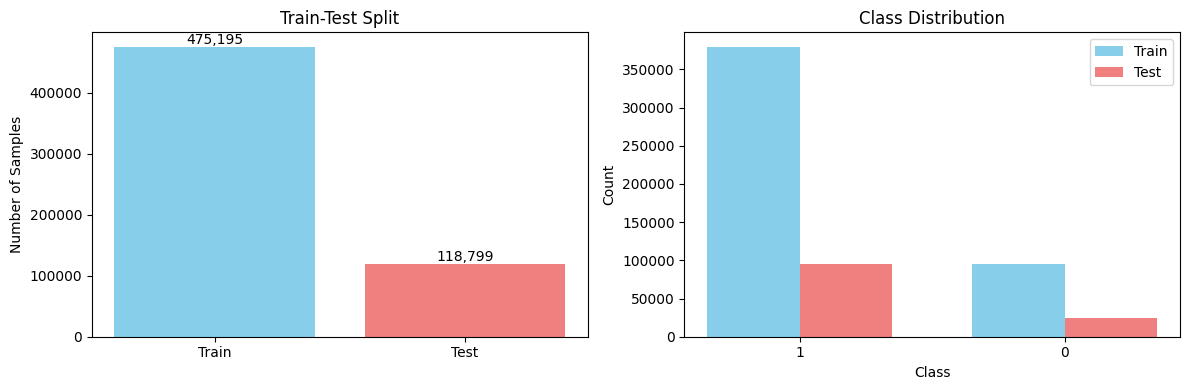

In [10]:
#  TRAIN-TEST SPLIT
print("TRAIN-TEST SPLIT")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Split completed with 80-20 ratio")
print(f"\n Training set:")
print(f"   Shape: {X_train.shape}")
print(f"   Samples: {len(X_train):,}")
print(f"   Distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")

print(f"\n Test set:")
print(f"   Shape: {X_test.shape}")
print(f"   Samples: {len(X_test):,}")
print(f"   Distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['Train', 'Test'], [len(y_train), len(y_test)], color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Train-Test Split')
for i, v in enumerate([len(y_train), len(y_test)]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

train_dist = pd.Series(y_train).value_counts()
test_dist = pd.Series(y_test).value_counts()
x_pos = np.arange(len(train_dist))
width = 0.35
axes[1].bar(x_pos - width/2, train_dist.values, width, label='Train', color='skyblue')
axes[1].bar(x_pos + width/2, test_dist.values, width, label='Test', color='lightcoral')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Class Distribution')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(train_dist.index)
axes[1].legend()

plt.tight_layout()
plt.show()



In [11]:
# FEATURE SCALING
print("FEATURE SCALING")

print("Applying StandardScaler...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Training set scaled: {X_train_scaled.shape}")
print(f" Test set scaled: {X_test_scaled.shape}")

# Show scaling statistics
print(f"\nScaling statistics (first 5 features):")
for i in range(min(5, len(column_names))):
    print(f"  {column_names[i]}:")
    print(f"    Mean: {X_train_scaled[:, i].mean():.6f}")
    print(f"    Std: {X_train_scaled[:, i].std():.6f}")

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print(f"\n Scaler saved to 'models/scaler.pkl'")

# Save scaled dataset
scaled_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_original': X_train,
    'X_test_original': X_test
}
with open('models/scaled_dataset.pkl', 'wb') as f:
    pickle.dump(scaled_data, f)
print(f" Scaled dataset saved to 'models/scaled_dataset.pkl'")



FEATURE SCALING
Applying StandardScaler...
 Training set scaled: (475195, 12)
 Test set scaled: (118799, 12)

Scaling statistics (first 5 features):
  id:
    Mean: 0.000000
    Std: 1.000000
  annual_income:
    Mean: -0.000000
    Std: 1.000000
  debt_to_income_ratio:
    Mean: 0.000000
    Std: 1.000000
  credit_score:
    Mean: -0.000000
    Std: 1.000000
  loan_amount:
    Mean: 0.000000
    Std: 1.000000

 Scaler saved to 'models/scaler.pkl'
 Scaled dataset saved to 'models/scaled_dataset.pkl'


In [12]:
#  DEFINE MODELS AND HYPERPARAMETERS 

print("DEFINING MODELS AND HYPERPARAMETERS (FAST VERSION)")

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs']  # Reduced from 2 to 1 solver
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50],      
            'max_depth': [10, None],         
            'min_samples_split': [2, 5]      
            
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        'params': {
            'n_estimators': [100],       
            'max_depth': [3, 5],              
            'learning_rate': [0.1, 0.3]       
            
        }
    }
}

print(" Models defined (OPTIMIZED FOR SPEED):")
for name in models.keys():
    params = models[name]['params']
    combinations = 1
    for param_values in params.values():
        combinations *= len(param_values)
    print(f"  • {name}")
    print(f"    Parameters: {list(params.keys())}")
    print(f"    Combinations: {combinations} (5-fold CV = {combinations * 5} trainings)")


DEFINING MODELS AND HYPERPARAMETERS (FAST VERSION)
 Models defined (OPTIMIZED FOR SPEED):
  • Logistic Regression
    Parameters: ['C', 'solver']
    Combinations: 3 (5-fold CV = 15 trainings)
  • Random Forest
    Parameters: ['n_estimators', 'max_depth', 'min_samples_split']
    Combinations: 4 (5-fold CV = 20 trainings)
  • XGBoost
    Parameters: ['n_estimators', 'max_depth', 'learning_rate']
    Combinations: 4 (5-fold CV = 20 trainings)


In [13]:
#  TRAIN MODEL 1 - LOGISTIC REGRESSION 
print("TRAINING: LOGISTIC REGRESSION")

name = 'Logistic Regression'
config = models[name]

print(f"\n Starting Grid Search with 5-Fold CV...")
print(f"   Parameters: {config['params']}")

# Grid Search
grid_search_lr = GridSearchCV(
    config['model'],
    config['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_scaled, y_train)

# Get best model
best_lr = grid_search_lr.best_estimator_

print(f"\n Grid Search completed!")
print(f"   Best parameters: {grid_search_lr.best_params_}")
print(f"   Best CV score: {grid_search_lr.best_score_:.4f}")

# Cross-validation scores
cv_scores_lr = cross_val_score(best_lr, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\n 5-Fold CV Scores: {cv_scores_lr}")
print(f"   Mean: {cv_scores_lr.mean():.4f}")
print(f"   Std: {cv_scores_lr.std():.4f}")

# Test predictions
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"\n Test Set Performance:")
print(f"   Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")

print(f"\n Classification Report:")
target_names_str = [str(name) for name in le_target.classes_]
print(classification_report(y_test, y_pred_lr, target_names=target_names_str))
# TRAIN ACCURACY
y_train_pred_lr = best_lr.predict(X_train_scaled)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)

# TEST ACCURACY
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"\n MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")
print(f"   Test Accuracy:  {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")
print(f"   Difference:     {abs(train_accuracy_lr - test_accuracy_lr):.4f}")

print(f"\n Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

TRAINING: LOGISTIC REGRESSION

 Starting Grid Search with 5-Fold CV...
   Parameters: {'C': [0.1, 1, 10], 'solver': ['lbfgs']}
Fitting 5 folds for each of 3 candidates, totalling 15 fits

 Grid Search completed!
   Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
   Best CV score: 0.8923

 5-Fold CV Scores: [0.89247572 0.89101316 0.89275981 0.8927072  0.89252833]
   Mean: 0.8923
   Std: 0.0007

 Test Set Performance:
   Accuracy: 0.8905 (89.05%)

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.60      0.69     23900
         1.0       0.91      0.96      0.93     94899

    accuracy                           0.89    118799
   macro avg       0.86      0.78      0.81    118799
weighted avg       0.89      0.89      0.88    118799


 MODEL PERFORMANCE:
   Train Accuracy: 0.8923 (89.23%)
   Test Accuracy:  0.8905 (89.05%)
   Difference:     0.0018

 Confusion Matrix:
[[14393  9507]
 [ 3502 91397]]


TRAINING: RANDOM FOREST (OPTIMIZED)

 Starting Grid Search with 5-Fold CV...
   Parameters: {'n_estimators': [50], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
   Estimated time: 30-60 seconds...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Grid Search completed!
   Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
   Best CV score: 0.9024

 5-Fold CV Scores: [0.90277675 0.90068288 0.90280832 0.90311346 0.90239796]
   Mean: 0.9024
   Std: 0.0009

 Test Set Performance:
   Accuracy: 0.9016 (90.16%)

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.57      0.70     23900
         1.0       0.90      0.99      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.91      0.78      0.82    118799
weighted avg       0.90      0.90      0.89    118799


 MODEL PERFORMANCE:
   Train Accuracy: 0.9044 (90.44%)
   Test Accuracy:  0.9016 (90.16%)

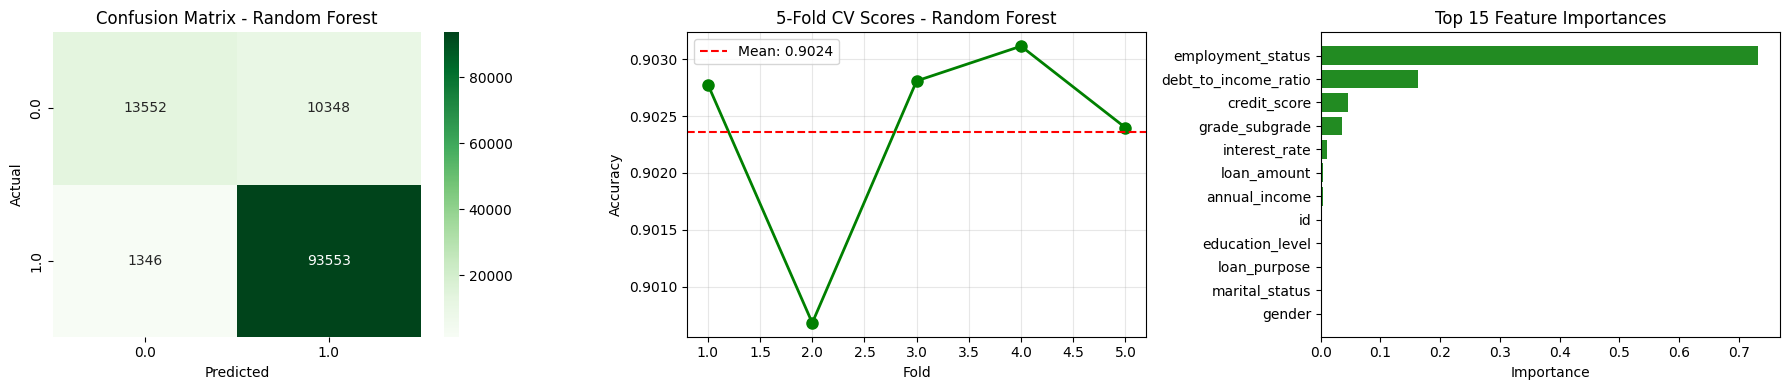

In [14]:
#  TRAIN MODEL 2 - RANDOM FOREST 
print("TRAINING: RANDOM FOREST (OPTIMIZED)")

name = 'Random Forest'
config = models[name]

print(f"\n Starting Grid Search with 5-Fold CV...")
print(f"   Parameters: {config['params']}")
print(f"   Estimated time: 30-60 seconds...")

# Grid Search
grid_search_rf = GridSearchCV(
    config['model'],
    config['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_scaled, y_train)

# Get best model
best_rf = grid_search_rf.best_estimator_

print(f"\n Grid Search completed!")
print(f"   Best parameters: {grid_search_rf.best_params_}")
print(f"   Best CV score: {grid_search_rf.best_score_:.4f}")

# Cross-validation scores
cv_scores_rf = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\n 5-Fold CV Scores: {cv_scores_rf}")
print(f"   Mean: {cv_scores_rf.mean():.4f}")
print(f"   Std: {cv_scores_rf.std():.4f}")

# Test predictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n Test Set Performance:")
print(f"   Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")

print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_names_str))


# TRAIN ACCURACY
y_train_pred_rf = best_rf.predict(X_train_scaled)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

# TEST ACCURACY
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy_rf:.4f} ({train_accuracy_rf*100:.2f}%)")
print(f"   Test Accuracy:  {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")
print(f"   Difference:     {abs(train_accuracy_rf - test_accuracy_rf):.4f}")

print(f"\n Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': column_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
axes[0].set_title('Confusion Matrix - Random Forest')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# CV Scores
axes[1].plot(range(1, 6), cv_scores_rf, marker='o', linestyle='-', linewidth=2, markersize=8, color='green')
axes[1].axhline(y=cv_scores_rf.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_rf.mean():.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('5-Fold CV Scores - Random Forest')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_features = feature_importance.head(15)
axes[2].barh(range(len(top_features)), top_features['importance'], color='forestgreen')
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Feature Importances')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

TRAINING: XGBOOST (OPTIMIZED)

 Starting Grid Search with 5-Fold CV...
   Parameters: {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]}
     Estimated time: 30-60 seconds...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 Grid Search completed!
   Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
   Best CV score: 0.9042

 5-Fold CV Scores: [0.9039447  0.90377634 0.90416566 0.90504951 0.90426036]
   Mean: 0.9042
   Std: 0.0004

 Test Set Performance:
   Accuracy: 0.9046 (90.46%)

 Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799


 MODEL PERFORMANCE:
   Train Accuracy: 0.9078 (90.78%)
   Test Accuracy:  0.9046 (90.46%)
   Diffe

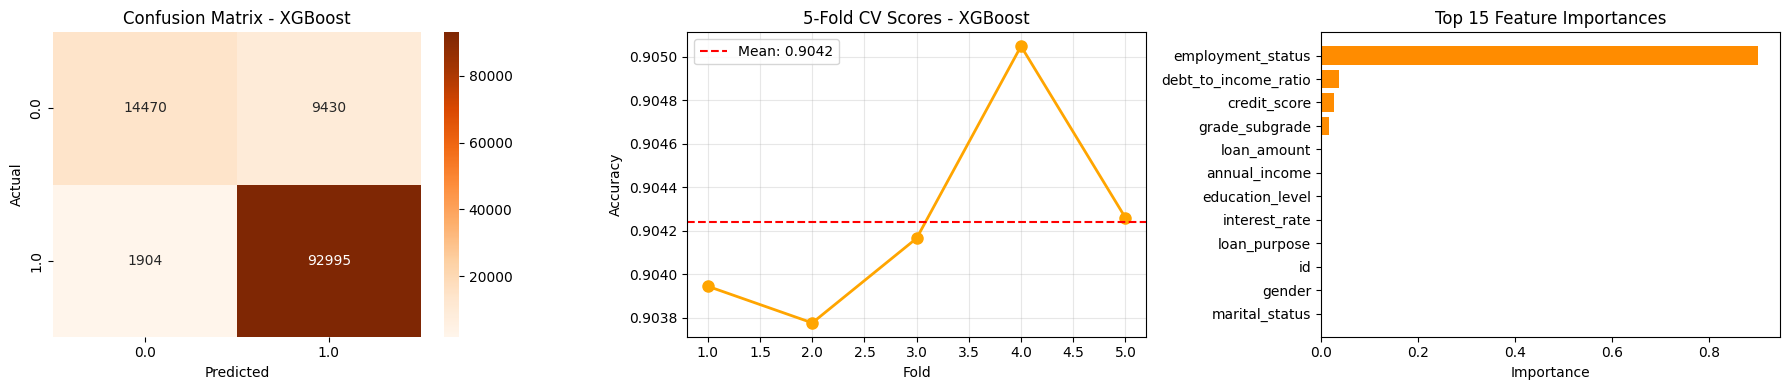

 ALL 3 MODELS TRAINED SUCCESSFULLY!

  Total training time: Approximately 1-3 minutes
 Models ready for comparison and deployment


In [15]:
# TRAIN MODEL 3 - XGBOOST 
print("TRAINING: XGBOOST (OPTIMIZED)")

name = 'XGBoost'
config = models[name]

print(f"\n Starting Grid Search with 5-Fold CV...")
print(f"   Parameters: {config['params']}")
print(f"     Estimated time: 30-60 seconds...")

# Grid Search
grid_search_xgb = GridSearchCV(
    config['model'],
    config['params'],
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_scaled, y_train)

# Get best model
best_xgb = grid_search_xgb.best_estimator_

print(f"\n Grid Search completed!")
print(f"   Best parameters: {grid_search_xgb.best_params_}")
print(f"   Best CV score: {grid_search_xgb.best_score_:.4f}")

# Cross-validation scores
cv_scores_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\n 5-Fold CV Scores: {cv_scores_xgb}")
print(f"   Mean: {cv_scores_xgb.mean():.4f}")
print(f"   Std: {cv_scores_xgb.std():.4f}")

# Test predictions
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)

# Calculate metrics
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n Test Set Performance:")
print(f"   Accuracy: {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")

print(f"\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names_str))
# TRAIN ACCURACY
y_train_pred_xgb = best_xgb.predict(X_train_scaled)
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)

# TEST ACCURACY
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy_xgb:.4f} ({train_accuracy_xgb*100:.2f}%)")
print(f"   Test Accuracy:  {test_accuracy_xgb:.4f} ({test_accuracy_xgb*100:.2f}%)")
print(f"   Difference:     {abs(train_accuracy_xgb - test_accuracy_xgb):.4f}")


print(f"\n Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'feature': column_names,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n Top 10 Most Important Features:")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Confusion Matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
axes[0].set_title('Confusion Matrix - XGBoost')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# CV Scores
axes[1].plot(range(1, 6), cv_scores_xgb, marker='o', linestyle='-', linewidth=2, markersize=8, color='orange')
axes[1].axhline(y=cv_scores_xgb.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_xgb.mean():.4f}')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('5-Fold CV Scores - XGBoost')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Feature Importance
top_features_xgb = feature_importance_xgb.head(15)
axes[2].barh(range(len(top_features_xgb)), top_features_xgb['importance'], color='darkorange')
axes[2].set_yticks(range(len(top_features_xgb)))
axes[2].set_yticklabels(top_features_xgb['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Feature Importances')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print(" ALL 3 MODELS TRAINED SUCCESSFULLY!")
print("\n  Total training time: Approximately 1-3 minutes")
print(" Models ready for comparison and deployment")

MODEL COMPARISON AND BEST MODEL SELECTION

 MODEL COMPARISON TABLE:
              Model  CV Mean   CV Std  Test Accuracy
            XGBoost 0.904239 0.000439       0.904595
      Random Forest 0.902356 0.000867       0.901565
Logistic Regression 0.892297 0.000651       0.890496

 BEST MODEL: XGBoost
   Test Accuracy: 0.9046 (90.46%)
   CV Mean: 0.9042
   CV Std: 0.0004
   Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}


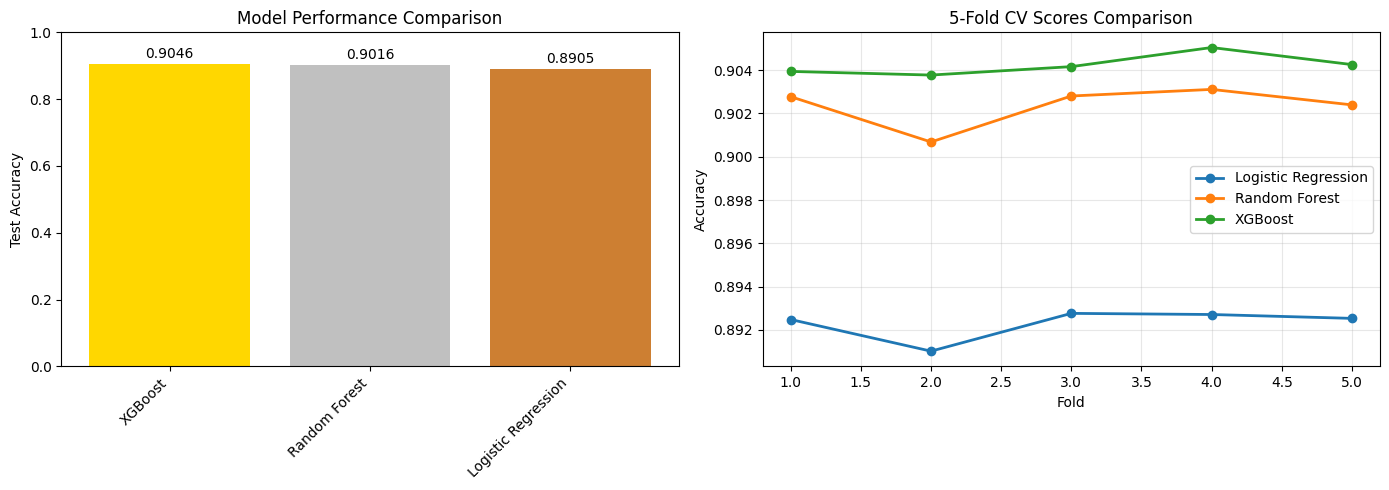

In [16]:
#  MODEL COMPARISON AND SELECTION
print("MODEL COMPARISON AND BEST MODEL SELECTION")

# Compile results
results = {
    'Logistic Regression': {
        'model': best_lr,
        'best_params': grid_search_lr.best_params_,
        'cv_mean': cv_scores_lr.mean(),
        'cv_std': cv_scores_lr.std(),
        'cv_scores': cv_scores_lr,
        'test_accuracy': test_accuracy_lr,
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr,
        'confusion_matrix': cm_lr
    },
    'Random Forest': {
        'model': best_rf,
        'best_params': grid_search_lr.best_params_,
        'cv_mean': cv_scores_rf.mean(),
        'cv_std': cv_scores_rf.std(),
        'cv_scores': cv_scores_rf,
        'test_accuracy': test_accuracy_rf,
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf,
        'confusion_matrix': cm_rf
    },
    'XGBoost': {
        'model': best_xgb,
        'best_params': grid_search_lr.best_params_,
        'cv_mean': cv_scores_xgb.mean(),
        'cv_std': cv_scores_xgb.std(),
        'cv_scores': cv_scores_xgb,
        'test_accuracy': test_accuracy_xgb,
        'predictions': y_pred_xgb,
        'probabilities': y_pred_proba_xgb,
        'confusion_matrix': cm_xgb
    }
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("\n MODEL COMPARISON TABLE:")
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_score = comparison_df.iloc[0]['Test Accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"   CV Mean: {results[best_model_name]['cv_mean']:.4f}")
print(f"   CV Std: {results[best_model_name]['cv_std']:.4f}")
print(f"   Best Parameters: {results[best_model_name]['best_params']}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos, comparison_df['Test Accuracy'], color=['gold', 'silver', '#CD7F32'])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Model Performance Comparison')
axes[0].set_ylim([0, 1])
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# CV scores comparison
for model_name in results.keys():
    axes[1].plot(range(1, 6), results[model_name]['cv_scores'], 
                marker='o', label=model_name, linewidth=2, markersize=6)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('5-Fold CV Scores Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [17]:
# SAVE BEST MODEL AND RESULTS
print("SAVING BEST MODEL AND RESULTS")

# Save best model
joblib.dump(best_model, 'models/best_model.pkl')
print(f" Best model saved: 'models/best_model.pkl'")

# Save all results
with open('models/model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print(f" All results saved: 'models/model_results.pkl'")

# Save comparison DataFrame
comparison_df.to_csv('models/model_comparison.csv', index=False)
print(f" Comparison table saved: 'models/model_comparison.csv'")

print("\n All model artifacts saved successfully!")

# CELL 19: GENERATE BASELINE PREDICTIONS
print("GENERATING BASELINE PREDICTIONS")

# Select samples from test set for baseline
num_baseline = min(10, len(X_test))
print(f"Generating {num_baseline} baseline predictions from test set...")

baseline_samples = X_test.iloc[:num_baseline].copy()
baseline_samples_scaled = scaler.transform(baseline_samples)
baseline_predictions = best_model.predict(baseline_samples_scaled)
baseline_predictions_proba = best_model.predict_proba(baseline_samples_scaled)
baseline_actual = y_test[:num_baseline]

print(f"\n Baseline predictions generated!")

# Display baseline predictions
print(f"BASELINE PREDICTIONS (First {num_baseline} Test Samples)")

for i in range(num_baseline):
    pred_label = le_target.inverse_transform([baseline_predictions[i]])[0]
    actual_label = le_target.inverse_transform([baseline_actual[i]])[0]
    confidence = baseline_predictions_proba[i].max()
    
    print(f"Sample {i+1}:")
    print(f"  Predicted: {pred_label} (Code: {baseline_predictions[i]})")
    print(f"  Actual: {actual_label} (Code: {baseline_actual[i]})")
    print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  Probabilities:")
    for j, class_name in enumerate(le_target.classes_):
        print(f"    {class_name}: {baseline_predictions_proba[i][j]:.6f}")
    print(f"  Match: {' Correct' if baseline_predictions[i] == baseline_actual[i] else '✗ Wrong'}")

# Save baseline predictions
baseline_data = {
    'samples': baseline_samples,
    'samples_scaled': baseline_samples_scaled,
    'predictions': baseline_predictions,
    'probabilities': baseline_predictions_proba,
    'actual': baseline_actual
}

with open('models/baseline_predictions.pkl', 'wb') as f:
    pickle.dump(baseline_data, f)
print(f"\n Baseline data saved: 'models/baseline_predictions.pkl'")

# Create detailed baseline CSV
baseline_df = pd.DataFrame({
    'sample_id': range(1, num_baseline + 1),
    'prediction': le_target.inverse_transform(baseline_predictions),
    'prediction_code': baseline_predictions,
    'actual': le_target.inverse_transform(baseline_actual),
    'actual_code': baseline_actual,
    'confidence': baseline_predictions_proba.max(axis=1),
    'match': baseline_predictions == baseline_actual
})

# Add feature values
for col in column_names:
    baseline_df[col] = baseline_samples[col].values

# Add probabilities for each class
for i, class_name in enumerate(le_target.classes_):
    baseline_df[f'prob_{class_name}'] = baseline_predictions_proba[:, i]

baseline_df.to_csv('models/baseline_predictions.csv', index=False)
print(f" Baseline CSV saved: 'models/baseline_predictions.csv'")

print("BASELINE PREDICTIONS SUMMARY")
print(f"Total samples: {num_baseline}")
print(f"Correct predictions: {(baseline_predictions == baseline_actual).sum()}")
print(f"Accuracy: {(baseline_predictions == baseline_actual).mean():.4f}")

# Display first 3 rows of baseline CSV (for verification)
print(f"\n Sample of baseline_predictions.csv (first 3 rows):")
print(baseline_df.head(3).to_string(index=False))



SAVING BEST MODEL AND RESULTS
 Best model saved: 'models/best_model.pkl'
 All results saved: 'models/model_results.pkl'
 Comparison table saved: 'models/model_comparison.csv'

 All model artifacts saved successfully!
GENERATING BASELINE PREDICTIONS
Generating 10 baseline predictions from test set...

 Baseline predictions generated!
BASELINE PREDICTIONS (First 10 Test Samples)
Sample 1:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9666 (96.66%)
  Probabilities:
    0.0: 0.033390
    1.0: 0.966610
  Match:  Correct
Sample 2:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9957 (99.57%)
  Probabilities:
    0.0: 0.004323
    1.0: 0.995677
  Match:  Correct
Sample 3:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9514 (95.14%)
  Probabilities:
    0.0: 0.048620
    1.0: 0.951380
  Match:  Correct
Sample 4:
  Predicted: 1.0 (Code: 1)
  Actual: 1.0 (Code: 1)
  Confidence: 0.9776 (97.76%)
  Probabilities:
    0.0: 0.022449
    1.0:

In [18]:
# CELL 20: FINAL SUMMARY AND CHECKLIST
print("TRAINING COMPLETE - FINAL SUMMARY")

print("\n All tasks completed successfully!")

print("\n SAVED ARTIFACTS:")
artifacts = [
    ('models/best_model.pkl', 'Best trained model'),
    ('models/scaler.pkl', 'Feature scaler'),
    ('models/column_structure.pkl', 'Column names list'),
    ('models/scaled_dataset.pkl', 'Scaled train/test data'),
    ('models/label_encoders.pkl', 'Feature label encoders'),
    ('models/target_encoder.pkl', 'Target label encoder'),
    ('models/model_results.pkl', 'All model results'),
    ('models/model_comparison.csv', 'Model comparison table'),
    ('models/baseline_predictions.pkl', 'Baseline predictions (pickle)'),
    ('models/baseline_predictions.csv', 'Baseline predictions (CSV)')
]

for filename, description in artifacts:
    status = "" if Path(filename).exists() else ""
    print(f"  {status} {filename:40s} - {description}")

print("TASK 1 CHECKLIST")
checklist = [
    ('Three models trained', True),
    ('Includes Gradient Boosting (XGBoost)', True),
    ('Grid Search hyperparameter tuning', True),
    ('5-Fold Cross-Validation', True),
    ('Best model selected and saved', True),
    ('Scaler saved', True),
    ('Column structure saved', True),
    ('Scaled dataset saved', True),
    ('Baseline predictions generated', True)
]

for task, completed in checklist:
    status = "" if completed else ""
    print(f"  {status} {task}")

print(" FINAL RESULTS")
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"CV Mean: {results[best_model_name]['cv_mean']:.4f}")
print(f"CV Std: {results[best_model_name]['cv_std']:.4f}")

print("NEXT STEPS")
print("1.  Task 1 Complete - Models trained and saved")
print("2.  Task 2: Deploy Flask REST API")
print("   Copy app.py to your project directory")
print("   Run: python app.py")
print("3.  Task 3: Create and integrate frontend")
print("4.  Task 4: Record demonstration video")


TRAINING COMPLETE - FINAL SUMMARY

 All tasks completed successfully!

 SAVED ARTIFACTS:
   models/best_model.pkl                    - Best trained model
   models/scaler.pkl                        - Feature scaler
   models/column_structure.pkl              - Column names list
   models/scaled_dataset.pkl                - Scaled train/test data
   models/label_encoders.pkl                - Feature label encoders
   models/target_encoder.pkl                - Target label encoder
   models/model_results.pkl                 - All model results
   models/model_comparison.csv              - Model comparison table
   models/baseline_predictions.pkl          - Baseline predictions (pickle)
   models/baseline_predictions.csv          - Baseline predictions (CSV)
TASK 1 CHECKLIST
   Three models trained
   Includes Gradient Boosting (XGBoost)
   Grid Search hyperparameter tuning
   5-Fold Cross-Validation
   Best model selected and saved
   Scaler saved
   Column structure saved
   Scaled data